In [99]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# 04 - Applied ML
## Question 1: Propensity score matching
### 0. Loading the dataset




In [69]:
lalonde_df = pd.read_csv('./lalonde.csv')
lalonde_df.head()


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

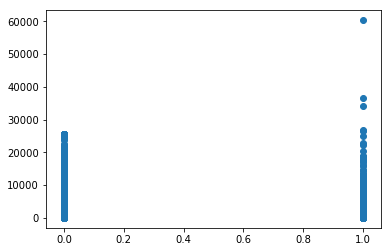

In [71]:
plt.scatter(lalonde_df.treat, lalonde_df.re78)

In [92]:
treated_df = lalonde_df[lalonde_df.treat == 1]
control_df = lalonde_df[lalonde_df.treat == 0]

print("Correlation:", lalonde_df.treat.corr(lalonde_df.re78))

pd.DataFrame(dict(treated = treated_df.re78.describe(), 
                  non_treated=control_df.re78.describe()))


Correlation: -0.0390327053015


,non_treated,treated
count,429.000000,185.000000
mean,6984.169742,6349.143530
std,7294.161791,7867.402218
min,0.000000,0.000000
25%,220.181300,485.229800
50%,4975.505000,4232.309000
75%,11688.820000,9642.999000
max,25564.670000,60307.930000


Naive interpretation :  
The treatment seems to have no effect to the outcome

### 2. A closer look at the data

In [97]:
treated_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [98]:
control_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


Treated group contains more "black" people (84%) than the the control group (only 20%).  
Moreover, the treated people were earn less money before the treatment 1974-1975 than the control people.
Furthermore, the ratio of married people in the treated group is less than the control group (19% against 51%).
Despite of having more or less the same years of education, the treated group has more no degree than the control one.  

**It seems that the two groups dont come from the same distribution.**

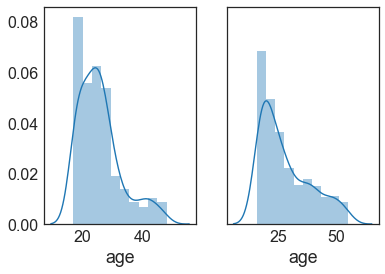

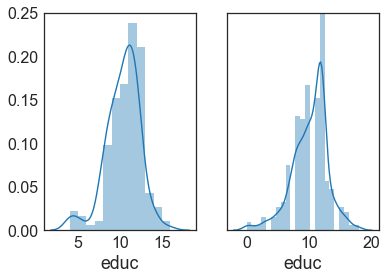

In [146]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(treated_df.age, ax=ax1)
sns.distplot(control_df.age, ax=ax2)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.distplot(treated_df.educ, ax=ax1)
sns.distplot(control_df.educ, ax=ax2)

As the two groups dont come frome the same distribution, the naive interpretation is not acceptable.

### 3. A propensity score model

In [170]:
from sklearn import linear_model

logistic= linear_model.LogisticRegression()

y = lalonde_df.treat
x = lalonde_df.drop(['treat', 'id', 're78'], axis=1)

logistic.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [210]:
proba = logistic.predict_proba(x)
propensity_score = proba[:, 1]

propensity_score_series = pd.Series(propensity_score)
propensity_df = lalonde_df.assign(propensity_score=propensity_score_series.values)
propensity_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


### 4. Balancing the dataset via matching

### 5. Balancing the groups further

### 6. A less naive analysis

## Question 2: Applied ML

### 1. Loading The 20 newsgroups text dataset


In [30]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [31]:
# We will print only the first rows
data_to_print = newsgroups_train.data[0:5]
target_to_print = newsgroups_train.target[0:5]

# Make a pandas dataframe from sklearn dataset
df = pd.DataFrame(np.c_[data_to_print, target_to_print], columns= np.append("Raw text", "Category"))
df.Category = df.Category.map(lambda cat_index: newsgroups_train.target_names[int(cat_index)])
df.head()

,Raw text,Category
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,sci.space


#### Compute TF-IDF features

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)

In [33]:
# We will print only the first rows
data_to_print = vectors.data[0:5]
target_to_print = newsgroups_train.target[0:5]

# Make a pandas dataframe from sklearn dataset
df = pd.DataFrame(np.c_[data_to_print, target_to_print], columns= np.append("TF-IDF", "Category"))
df.Category = df.Category.map(lambda cat_index: newsgroups_train.target_names[int(cat_index)])
df.head()

,TF-IDF,Category
0,0.057470,rec.autos
1,0.353835,comp.sys.mac.hardware
2,0.259709,comp.sys.mac.hardware
3,0.211868,comp.graphics
4,0.054614,sci.space


#### Split train and test/val set
We split the loaded data into 3 subsets : 
- Training set (80%)
- Test set (10%)
- Validation set (10%

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectors, newsgroups_train.target, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(vectors, newsgroups_train.target, test_size=0.5, random_state=42)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Validation set shape:", X_val.shape)

Train set shape: (9051, 130107)
Test set shape: (5657, 130107)
Validation set shape: (5657, 130107)


### 2 Classification with Random forest

#### Using default hyperparameters : 


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [36]:
preds = clf.predict(X_test) 

In [37]:
print("Test Accuracy:", accuracy_score(y_test, preds))
print("Validation Accuracy :", accuracy_score(y_val, clf.predict(X_val)))

Test Accuracy: 0.853809439632
Validation Accuracy : 0.998232278593


In [38]:
# https://gist.github.com/nickynicolson/202fe765c99af49acb20ea9f77b6255e
# Convert a sklearn confusion matrix output to an elegant dataframe
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]


confusion_matrix_df = cm2df(confusion_matrix(y_test, preds), newsgroups_train.target_names)
confusion_matrix_df

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,205,1,1,0,0,0,0,1,0,1,1,1,0,3,0,11,1,1,1,5
comp.graphics,1,243,12,3,2,5,5,1,0,3,0,2,2,2,2,0,2,0,0,0
comp.os.ms-windows.misc,0,17,249,11,1,3,4,0,0,2,0,0,3,0,2,0,0,0,1,0
comp.sys.ibm.pc.hardware,2,19,14,236,7,4,10,1,0,1,0,0,5,1,0,1,0,0,0,0
comp.sys.mac.hardware,0,11,6,25,229,1,4,4,2,2,1,0,5,2,0,2,2,0,0,0
comp.windows.x,1,7,4,5,6,260,1,0,0,0,1,0,0,0,0,0,0,0,0,0
misc.forsale,1,5,3,6,3,1,250,6,2,0,1,0,2,1,0,0,0,0,0,0
rec.autos,4,5,3,6,5,2,8,261,5,5,0,1,3,1,0,1,1,1,0,0
rec.motorcycles,3,3,0,1,2,0,4,9,293,0,1,0,1,1,0,1,0,0,0,0
rec.sport.baseball,0,3,2,3,3,3,3,1,2,254,8,0,0,0,0,1,0,1,0,0


#### Grid search cross validation : 

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
           "n_estimators" : [63, 65],
           "max_depth" : [30, 40]}
 
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 40, 'n_estimators': 65}

In [40]:
print("Grid score :")
grid_search.grid_scores_

Grid score :


C:\Users\Coac\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.75152, std: 0.00168, params: {'max_depth': 30, 'n_estimators': 63},
 mean: 0.75318, std: 0.00135, params: {'max_depth': 30, 'n_estimators': 65},
 mean: 0.75671, std: 0.00683, params: {'max_depth': 40, 'n_estimators': 63},
 mean: 0.75970, std: 0.00716, params: {'max_depth': 40, 'n_estimators': 65}]

In [41]:
"Best score", grid_search.best_score_

('Best score', 0.75969506131919129)

In [42]:
test = RandomForestClassifier(n_jobs=2, random_state=0, max_depth=30, n_estimators=63)
test.fit(X_train, y_train)
print("Validation Accuracy :", accuracy_score(y_val, test.predict(X_val)))

Validation Accuracy : 0.946968357787
